In [276]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [277]:
# 设置 Matplotlib 支持中文
matplotlib.rc("font", family="SimHei")  # 使用黑体
plt.rcParams["axes.unicode_minus"] = False  # 解决负号显示问题

## 区域划分

In [278]:
data = pd.read_csv('../data/深圳市定点零售药品名单_包含坐标.csv')
medicine_shop = pd.read_csv('../data/深圳市定点零售药品名单_包含坐标.csv')
center = pd.read_csv('../data/深圳市药品配送中心.csv',encoding='gbk')
center.head(2)

,配送中心,X,Y
0,九州通,114.380103,22.687209
1,国药物流,114.032279,22.760200


### 数据清洗

In [279]:
# 洗掉坐标为（0,0）的数据
medicine_shop = medicine_shop[(medicine_shop['X'] != 0) & (medicine_shop['Y'] != 0)].dropna()
center = center[(center['X'] != 0) & (center['Y'] != 0)].dropna()

In [280]:
# 提取经纬度
shop_locations = medicine_shop[['X', 'Y']].values
center_locations = center[['X', 'Y']].values

In [281]:
# 设置 KMeans，指定初始聚类中心
kmeans = KMeans(n_clusters=len(center_locations), init=center_locations, n_init=1, max_iter=300)
medicine_shop['Cluster'] = kmeans.fit_predict(shop_locations)

In [282]:
# 计算评估指标
sse = kmeans.inertia_
silhouette_avg = silhouette_score(shop_locations, medicine_shop['Cluster'])
db_index = davies_bouldin_score(shop_locations, medicine_shop['Cluster'])

In [283]:
print(f"SSE: {sse:.2f}")
print(f"Silhouette Score: {silhouette_avg:.2f}")
print(f"Davies-Bouldin Index: {db_index:.2f}")

SSE: 42.31
Silhouette Score: 0.46
Davies-Bouldin Index: 0.80


D:\Temp\ipykernel_22296\1224840119.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(center_coords))  # 生成不同颜色
D:\Temp\ipykernel_22296\1224840119.py:31: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(center.iloc[i]['X'], center.iloc[i]['Y'],


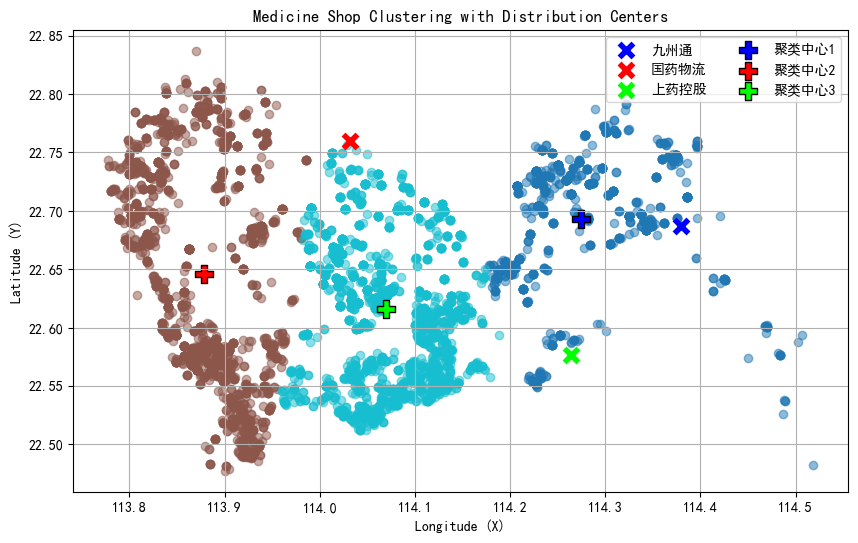

In [284]:
# 去除 X, Y 值为 0 的数据
medicine_shop = medicine_shop[(medicine_shop["X"] != 0) & (medicine_shop["Y"] != 0)]
center = center[(center["X"] != 0) & (center["Y"] != 0)]

# 提取坐标
shop_coords = medicine_shop[["X", "Y"]].values
center_coords = center[["X", "Y"]].values

# 使用配送中心作为初始聚类中心
kmeans = KMeans(n_clusters=len(center_coords), init=center_coords, n_init=1, random_state=42)
labels = kmeans.fit_predict(shop_coords)
cluster_centers = kmeans.cluster_centers_

# 画图
plt.figure(figsize=(10, 6))
colors = plt.cm.get_cmap("tab10", len(center_coords))  # 生成不同颜色

# color_list = ["#00008B", "#8B4513", "#20B2AA"]
color_list = ["#0000FF", "#FF0000", "#00FF00"]

for i in range(len(center_coords)):
    # 获取属于第 i 簇的点阿
    cluster_points = shop_coords[labels == i]
    
    # 画聚类点（小圆点 'o'）
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                color=colors(i), alpha=0.5)

# 配送中心
for i in range(len(center)):
    plt.scatter(center.iloc[i]['X'], center.iloc[i]['Y'], 
                linewidths=4, marker='x', s=100, alpha=1.0,
                edgecolors="black", c=color_list[i], 
                label=center.iloc[i]['配送中心'])

for i in range(len(center_coords)):
    # 画聚类中心（配送中心更明显）
    plt.scatter(cluster_centers[i, 0], cluster_centers[i, 1], 
                color=color_list[i], marker="P", s=150, edgecolors='black',
                linewidths=1, alpha=1.0, label=f"聚类中心{i+1}")
# 添加图例
plt.xlabel("Longitude (X)")
plt.ylabel("Latitude (Y)")
plt.title("Medicine Shop Clustering with Distribution Centers")
plt.legend(ncol=2)
plt.grid()
plt.show()

## 需求量获取

In [285]:
population = pd.read_csv('./深圳各区人口系数.csv')
season = pd.read_csv('./季节系数.csv', encoding='gbk')

In [286]:
def produce_req(row, population, season):
    base = 1000
    district = row['辖区']
    time = 3

    # 从人口系数表中提取对应区域的建议系数
    pop_coefficient = population.loc[population['区域'] == district, '建议系数']
    if pop_coefficient.empty:
        raise ValueError(f"未找到区域：{district}")

    # 从季节系数表中提取对应月份的系数
    season_coefficient = season.loc[season['月份'] == time, '系数']
    if season_coefficient.empty:
        raise ValueError(f"未找到月份：{time}")

    # 计算需求量
    req = base * pop_coefficient.iloc[0] * season_coefficient.iloc[0] + np.random.normal(loc=200, scale=200)
    return np.floor(req)


In [287]:
medicine_shop['demand'] = medicine_shop.apply(produce_req, axis=1, population=population, season=season)

In [288]:
medicine_shop.head()

,Unnamed: 0,序号,辖区,零售药店代码（国家）,零售药店名称,地址,X,Y,Cluster,demand
0,0,1,南山区,P44030504506,深圳市健华药业连锁有限公司,深圳市南山区桃源街道桃源社区北环大道方大广场（一期）3、4号研发楼3号楼805,113.972673,22.556772,2,1049.0
1,1,2,宝安区,P44030602632,深圳市健华药业连锁有限公司锦花分店,深圳市宝安区西乡街道固戍下围园工业区A栋1F103号,113.844884,22.596670,1,2579.0
2,2,3,宝安区,P44030602643,深圳市健华药业连锁有限公司流塘分店,广东省深圳市宝安区西乡街道流塘社区工业路38号－2,113.885481,22.569978,1,2843.0
3,3,4,宝安区,P44030602642,深圳市健华药业连锁有限公司流塘新村分店,深圳市宝安区西乡街道流塘社区新村6巷9号一楼101铺,113.885680,22.579188,1,2980.0
4,4,5,宝安区,P44030602645,深圳市健华药业连锁有限公司奇生分店,深圳市宝安区西乡街道固戍社区固戍一路849号,113.849231,22.596885,1,2489.0


## VRP建模

### 简单案例

In [289]:
medicine_shop.to_csv('./data.csv')

In [290]:
# 定义载重上限
max_capacity = 40000

data = medicine_shop.sample(100)
df = pd.DataFrame(data)

In [303]:
import pygad

def distance(point1, point2):
    # 将经纬度转换为弧度
    lat1, lon1, lat2, lon2 = map(np.radians, [point1[0], point1[1], point2[0], point2[1]])
        
    # 计算纬度和经度的差值
    delta_lat = lat2 - lat1
    delta_lon = lon2 - lon1
        
    # 应用 Haversine 公式
    a = np.sin(delta_lat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(delta_lon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
        
    # 地球平均半径（公里）
    R = 6371.0
    distance = R * c
        
    return distance

# 解析路径
def parse_route(solution):
    routes = []
    current_route = []
    current_capacity = 0
        
    for idx in solution:
        demand = df.loc[idx, 'demand']
        if current_capacity + demand > max_capacity:
            # 如果超出载重限制，结束当前子路径
            routes.append(current_route)
            current_route = []
            current_capacity = 0
        current_route.append(idx)
        current_capacity += demand
        
        # 添加最后一个子路径
    if current_route:
        routes.append(current_route)
        
    return routes

def ga_vrp(df, num_points, center_x, center_y, name):    

    # 适应度函数：计算路径的总距离，并考虑载重约束
    def fitness_func(ga_instance, solution, solution_idx):
        total_distance = 0
        current_capacity = 0
        current_point = (center_x, center_y)  # 配送中心
        
        for idx in solution:
            idx = int(idx)
            next_point = (df.loc[idx, 'X'], df.loc[idx, 'Y'])
            demand = df.loc[idx, 'demand']
            
            # 检查载重约束
            if current_capacity + demand > max_capacity:
                # 如果超出载重限制，返回到配送中心并重新开始
                total_distance += distance(current_point, (center_x, center_y))
                current_point = (center_x, center_y)
                current_capacity = 0
            
            total_distance += distance(current_point, next_point)
            current_point = next_point
            current_capacity += demand
        
        # 最后返回配送中心
        total_distance += distance(current_point, (center_x, center_y))
        
        # 适应度值为总距离的倒数
        return 1 / (1 + total_distance)

    fitness_history = []
    # 回调函数 记录适应度
    def on_generation(ga_instance):
        # 获取当前代的适应度值
        current_fitness = ga_instance.best_solution()[1]
        # 保存适应度值
        fitness_history.append(current_fitness)

    # 初始化遗传算法
    ga_instance = pygad.GA(num_generations=200,  # 运行200代
                        num_parents_mating=5,  # 每代选择20个父代
                        fitness_func=fitness_func,  # 适应度函数
                        sol_per_pop=100,  # 种群大小为100
                        num_genes=num_points,  # 每个解有num_points个基因
                        init_range_low=0,  # 基因值的最小值为0
                        init_range_high=num_points - 1,  # 基因值的最大值为num_points - 1
                        mutation_percent_genes=20,  # 20%的基因发生变异
                        gene_space=df.index.to_list(),
                        allow_duplicate_genes=False,  # 禁止重复基因
                        crossover_type="single_point",  # 单点交叉
                        mutation_type="swap",
                        on_generation=on_generation)  # 交换变异

    # 运行遗传算法
    ga_instance.run()

    # 输出最优解
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    print(f"配送中心：{name}")
    print(f"最优路径: {solution}")
    print(f"适应度值: {solution_fitness}")

    # 输出路径
    routes = parse_route(solution)
    print("车辆路径:")
    for i, route in enumerate(routes):
        print(f"子路径 {i+1}: {route}")

    return fitness_history

## 算法比较

### 与其它算法比较

In [304]:
from pyswarm import pso

# 粒子群优化算法的调用部分
def pso_vrp(df, num_points, center_x, center_y, max_capacity):

    # 定义粒子群优化算法的适应度函数
    def fitness_func(solution):
        total_distance = 0
        current_capacity = 0
        current_point = (center_x, center_y)  # 配送中心
        
        # 将浮点解四舍五入为整数
        solution = np.round(solution).astype(int)
        
        for idx in solution:
            idx = int(idx)
            next_point = (df.loc[idx, 'X'], df.loc[idx, 'Y'])
            demand = df.loc[idx, 'demand']
            
            # 检查载重约束
            if current_capacity + demand > max_capacity:
                # 如果超出载重限制，返回到配送中心并重新开始
                total_distance += distance(current_point, (center_x, center_y))
                current_point = (center_x, center_y)
                current_capacity = 0
            
            total_distance += distance(current_point, next_point)
            current_point = next_point
            current_capacity += demand
        
        # 最后返回配送中心
        total_distance += distance(current_point, (center_x, center_y))
        
        # 适应度值为总距离的倒数
        return 1 / (1 + total_distance)

    # 定义粒子的初始位置和速度的上下界
    lb = [0] * num_points  # 下界
    ub = [num_points - 1] * num_points  # 上界
    
    # 粒子群优化
    xopt, fopt = pso(fitness_func, lb, ub, swarmsize=50, maxiter=200)
    
    # 将浮点解四舍五入为整数
    xopt = np.round(xopt).astype(int)
    
    # 确保路径索引的唯一性
    xopt = np.unique(xopt)
    
    # 输出最优解
    print(f"最优路径: {xopt}")
    print(f"适应度值: {fopt}")
    
    # 解析路径
    routes = parse_route(xopt)
    print("车辆路径:")
    for i, route in enumerate(routes):
        print(f"子路径 {i+1}: {route}")
    
    return xopt, fopt

# group_by
for idx, frame in df.groupby('Cluster'):
    print('-' * 10)
    fn = pso_vrp(frame, frame.shape[0], center.loc[idx, 'X'], center.loc[idx, 'Y'], center.loc[idx, '配送中心'])

----------


KeyError: 8